# IMDB Dataset of 50K Movie Reviews 

Welcome to the notebook on building a prediction model in classifying sentiments from movie reviews with TensorFlow 2.0 :D


# Dataset
This IMDB dataset was published by Maas et al for binary sentiment classification studies. It contains 50k movie reviews in English and is considered as haviing more data from some other datasets. The dataset provides 50000 highly polar movie reviews and sentiment labels (positive/negative)

For the original dataset and paper please read Learning Word Vectors for Sentiment Analysis (Maas et al., ACL2011) http://ai.stanford.edu/~amaas/data/sentiment/
# Method
Sentiment labels were transformed into binary labels (0,1). Movie reviews were tokenized with gensim functionality by mapping words to the top 5000 frequent words in the reviews. The tokenized reviews were one hot encoded and standardized. A artifical neural network with 2 hidden layers was constructed and compiled. To reduce overfitting, adam (adaptative moment estimated) was used to adjust learning rate. Dropout and early stopping were adopted as well. The resultant model has test accuracy of ~85% with >0.9 recall and >0.7 precision. 

# Hardware check

In [89]:
from __future__ import print_function
import psutil
print(psutil.cpu_percent())
print(psutil.virtual_memory())  # physical memory usage
print('memory % used:', psutil.virtual_memory()[2])

25.4
svmem(total=17092800512, available=6497026048, percent=62.0, used=10595774464, free=6497026048)
memory % used: 62.0


In [91]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Import modules

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\user\appdata\local\temp\pip-req-build-x3a28eko
  Resolved https://github.com/tensorflow/docs to commit 881afa31a959c86c39664c1d81d00e453eddf3f2
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\User\AppData\Local\Temp\pip-req-build-x3a28eko'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.corpora.dictionary import Dictionary as gdict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import gc

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
df_raw = pd.read_csv('IMDBDataset.csv')

In [5]:
df_raw.shape

(50000, 2)

In [6]:
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df_raw['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Data preparation

In [8]:
df = df_raw.copy()

In [9]:
# map sentiment into binary variables

binary_map =  {'negative':0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(binary_map)

In [10]:
reviews_raw = df['review']

In [11]:
reviews_raw

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [12]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [13]:
def convert_lower(text):
    return text.lower()

In [14]:
df['review'] = df['review'].apply(convert_lower)

In [15]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [16]:
del df_raw
del reviews_raw
gc.collect()

0

# Tokenize to map the words into integers

In [17]:
df["review"] = df["review"].map(lambda x: x.split(' '))

In [18]:
my_dict = gdict(df['review'])

In [19]:
len(my_dict)

392053

In [20]:
my_dict.filter_extremes(no_below=1, no_above=1, keep_n=5000)

In [21]:
df["bow"] = df["review"].map(my_dict.doc2bow)

In [22]:
df.head()

,review,sentiment,bow
0,"[one, of, the, other, reviewers, has, mentione...",1,"[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3..."
1,"[a, wonderful, little, production., <br, /><br...",1,"[(0, 3), (3, 3), (5, 4), (6, 1), (8, 2), (10, ..."
2,"[i, thought, this, was, a, wonderful, way, to,...",1,"[(0, 2), (5, 6), (10, 4), (12, 1), (16, 2), (1..."
3,"[basically, there's, a, family, where, a, litt...",0,"[(0, 3), (5, 10), (8, 3), (10, 4), (12, 2), (1..."
4,"[petter, mattei's, ""love, in, the, time, of, m...",1,"[(0, 4), (3, 2), (5, 6), (6, 2), (8, 2), (10, ..."


In [23]:
df2 = pd.concat([pd.DataFrame(s).set_index(0) for s in df["bow"]], axis=1).fillna(0).T.set_index(df.index)

In [24]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,2.0,0.0,6.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df2.astype('int32')

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3,1,1,1,1,3,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,3,0,4,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,10,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,2,0,6,2,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,0,0,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,2,0,0,1,0,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
49997,2,0,0,0,0,7,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,3,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df2.shape

(50000, 5000)

In [27]:
df['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [28]:
df_preprocessed = pd.concat([df2,df['sentiment']], axis=1)

In [29]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 5001 entries, 0 to sentiment
dtypes: float64(5000), int64(1)
memory usage: 1.9 GB


In [30]:
df_preprocessed.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,sentiment
0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,3.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4.0,0.0,0.0,2.0,0.0,6.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [31]:
del df
del df2
del my_dict
gc.collect()

0

## Check balance

In [32]:
df_preprocessed['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [33]:
sum_token = df_preprocessed.iloc[:, :5000].sum(axis=1)

In [34]:
df_check_token_balanced = pd.concat([sum_token, df_preprocessed['sentiment']], axis=1)

In [35]:
df_check_token_balanced.columns

Index([0, 'sentiment'], dtype='object')

In [36]:
df_check_token_balanced.iloc[-1].unique()

array([116.,   0.])

In [37]:
df_check_token_balanced.value_counts()

0       sentiment
117.0   1            212
115.0   0            210
111.0   0            207
113.0   0            202
119.0   0            197
                    ... 
740.0   0              1
741.0   1              1
743.0   1              1
744.0   1              1
1909.0  1              1
Length: 1676, dtype: int64

In [38]:
df_check_token_balanced.columns =['sum_token', 'sentiment']

In [39]:
df_check_token_balanced.head()

,sum_token,sentiment
0,248.0,1
1,133.0,1
2,140.0,1
3,117.0,0
4,193.0,1


<AxesSubplot:xlabel='sentiment', ylabel='sum_token'>

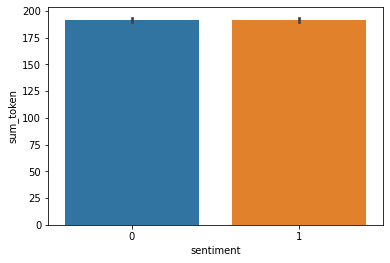

In [40]:
sns.barplot(data = df_check_token_balanced, x = "sentiment" , y ="sum_token")

<AxesSubplot:xlabel='sentiment', ylabel='sum_token'>

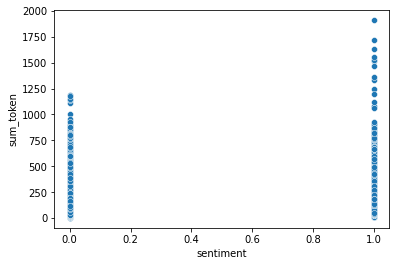

In [41]:
sns.scatterplot(data = df_check_token_balanced, x = "sentiment" , y ="sum_token")

In [42]:
# this line takes 5mins+ and may use up all memories
# df_preprocessed.to_csv('data_processed.csv', header=0)

In [43]:
del df_check_token_balanced
gc.collect()

0

# Declaring observations and targets

In [44]:
df_preprocessed.shape

(50000, 5001)

In [45]:
df_preprocessed = df_preprocessed.astype('float32')

In [46]:
#df_preprocessed.iloc[-1]

In [47]:
X = df_preprocessed.iloc[:, :5000]

In [48]:
y = df_preprocessed.iloc[:, -1].copy()

In [49]:
X.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
y.head(2)

0    1.0
1    1.0
Name: sentiment, dtype: float32

In [51]:
del df_preprocessed
gc.collect()

0

# Standardize X

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size= 0.2, random_state = 42)

In [54]:
#y_train.info()

In [55]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [56]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 5000)
(10000, 5000)
(40000,)
(10000,)


In [57]:
del X_scaled,y
gc.collect()

0

# Network functions

In [58]:
BATCH_SIZE = 500
STEPS_PER_EPOCH = 40000/BATCH_SIZE

In [59]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [60]:
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [61]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=150),
        tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [62]:
def compile_and_fit(model, name, f_xtrain, f_ytrain, f_xval, f_yval, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()
    
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.BinaryCrossentropy(
                              name='binary_crossentropy'),
                              'accuracy'])

    history = model.fit(
        x = X_train,
        y = y_train,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=(X_val, y_val) ,
        callbacks=get_callbacks(name),
        verbose=2)
    
    return history

# Model performance

In [63]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu',input_shape=(5000,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [64]:
dict_histories = {}

In [65]:
X_train_1 = X_train[3000:]
X_val = X_train[:3000]
y_train_1 = y_train[3000:]
y_val = y_train[:3000]

In [66]:
dict_histories['ver1'] = compile_and_fit(model = model_1, name ='ver1',
                                         f_xtrain = X_train_1,f_ytrain = y_train_1, 
                                         f_xval = X_val, f_yval = y_val)

Epoch 1/10000

Epoch: 0, accuracy:0.7762,  binary_crossentropy:0.4628,  loss:0.4628,  val_accuracy:0.9147,  val_binary_crossentropy:0.2340,  val_loss:0.2340,  
.80/80 - 7s - loss: 0.4628 - binary_crossentropy: 0.4628 - accuracy: 0.7762 - val_loss: 0.2340 - val_binary_crossentropy: 0.2340 - val_accuracy: 0.9147 - 7s/epoch - 92ms/step
Epoch 2/10000
.80/80 - 1s - loss: 0.2457 - binary_crossentropy: 0.2457 - accuracy: 0.9053 - val_loss: 0.1552 - val_binary_crossentropy: 0.1552 - val_accuracy: 0.9513 - 746ms/epoch - 9ms/step
Epoch 3/10000
.80/80 - 1s - loss: 0.1755 - binary_crossentropy: 0.1755 - accuracy: 0.9377 - val_loss: 0.1120 - val_binary_crossentropy: 0.1120 - val_accuracy: 0.9697 - 747ms/epoch - 9ms/step
Epoch 4/10000
.80/80 - 1s - loss: 0.1289 - binary_crossentropy: 0.1289 - accuracy: 0.9564 - val_loss: 0.0767 - val_binary_crossentropy: 0.0767 - val_accuracy: 0.9800 - 745ms/epoch - 9ms/step
Epoch 5/10000
.80/80 - 1s - loss: 0.0938 - binary_crossentropy: 0.0938 - accuracy: 0.9689 - 

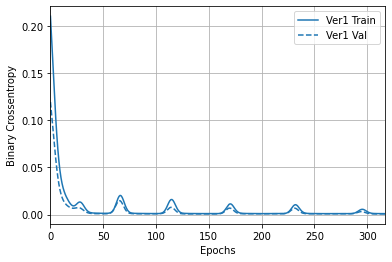

In [67]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(dict_histories)

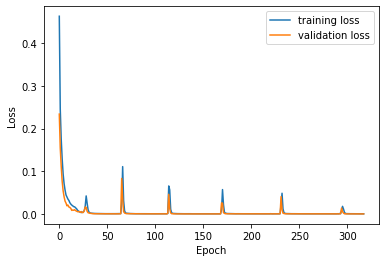

In [68]:
plt.plot(dict_histories['ver1'].history['loss'], label='training loss')
plt.plot(dict_histories['ver1'].history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [69]:
test_results = {}

test_results['model'] = model_1.evaluate(
    X_test, y_test, verbose=1)

print(test_results)

313/313 [==============================] - 1s 3ms/step - loss: 2.9468 - binary_crossentropy: 2.9468 - accuracy: 0.8549
{'model': [2.946842670440674, 2.946842670440674, 0.8549000024795532]}


In [70]:
result = model_1.predict(X_test)

313/313 [==============================] - 0s 1ms/step


In [71]:
res = tf.math.confusion_matrix(y_test, result)

In [72]:
print(res)

tf.Tensor(
[[4658  303]
 [1546 3493]], shape=(2, 2), dtype=int32)


In [78]:
# precision
from tensorflow.python.ops.numpy_ops import np_config 
np_config.enable_numpy_behavior()
res.tolist()



[[4658, 303], [1546, 3493]]

In [83]:
# precision
res[1,1]/(res[1,1]+res[1,0])

<tf.Tensor: shape=(), dtype=float64, numpy=0.6931930938678309>

In [82]:
#recall 
res[1,1]/(res[1,1]+res[0,1])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9201791359325606>

# Discussion

* The model reached >99% test and validation accuracy within first 20 epoch
* Standardization of features reduced most of the "Loss spikes". Scatterplot of features vs labels shows like negative class has less info than positive class. "Loss spikes" still occurs per ~50 epochs but each occurence has a lower magnitude. 
* One hot encoding was used in this study so this model suffers from the curse of dimensionality. Word2Vec may further improve the model performance.

# Reference
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

# Remarks
Thank you for checking by. 
I look forward for any feedbacks :) 